In [1]:
%matplotlib inline
import numpy
import pandas
import matplotlib.pyplot as plt

In [2]:
import os, sys
sys.path.append('../functions')

# Read Data

In [3]:
data = pandas.read_csv('Data/hits.csv', index_col=0)
data['IsStereo'] = (data.ViewNb.values == 1) * 1. + (data.ViewNb.values == 2) * 1.

data.head()

,EventID,TrackID,PdgCode,DetectorID,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,Px,...,dist2Wire,Wx1,Wx2,Wy1,Wy2,Wz,Wz1,Wz2,Label,IsStereo
79,2,2,-211,10002284,1,0,0,0,284,0.866347,...,0.042245,-250.000000,250.000000,0.868600,0.868600,2581.1500,2581.1500,2581.1500,0,0
111,2,2,-211,42012282,4,2,0,1,282,0.867240,...,0.478996,-248.589486,249.507863,27.037487,-16.540384,3542.3793,3542.3793,3542.3793,0,1
81,2,2,-211,11012288,1,1,0,1,288,0.866625,...,0.310706,-248.587499,249.509850,-27.060200,16.517671,2592.3793,2592.3793,2592.3793,0,1
43,2,3,-13,11012286,1,1,0,1,286,-0.239448,...,0.117904,-248.894287,249.203062,-23.553595,20.024276,2592.3793,2592.3793,2592.3793,1,1
88,2,2,-211,20012285,2,0,0,1,285,0.866401,...,0.437575,-250.000000,250.000000,-0.011400,-0.011400,2782.2500,2782.2500,2782.2500,0,0


In [48]:

from sklearn.cross_validation import train_test_split

event_ids = numpy.unique(data.EventID.values)
event_ids_train, event_ids_test= train_test_split(event_ids, train_size=100, random_state=42)
#event_ids_train, event_ids_valid = train_test_split(event_ids_train, train_size=0.5, random_state=42)

print len(event_ids_train)

100


# Train Classifier for the Tracks Combination

In [51]:
%%time

from combination import SuperCombinator
from multiprocessing import Pool
from utils import merge_dicts

event_ids = event_ids_train
tracks = {}

def tracks_reconstruction(event_id):
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = SimpleTemplateMatching(n_max_hits=16, n_min_hits=7, window_width=0.7)
    stm_stereo = SimpleTemplateMatching(n_max_hits=16, n_min_hits=6, window_width=15)
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    
    # Save the hits labels and the tracks parameters 
    one_track = {}
    
    one_track[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                           'labels34':labels34, 'params34':tracks_params34}
    
    return one_track

if __name__ == "__main__":
    p = Pool(3)
    results = p.map(tracks_reconstruction, event_ids)
    tracks = merge_dicts(results)

CPU times: user 29.7 ms, sys: 21 ms, total: 50.8 ms
Wall time: 16.6 s


In [53]:
sc = SuperCombinator()

combination_data = sc.data_collection(tracks, data)

X_data = combination_data[combination_data.columns[:-1]].values
y_data = combination_data.label.values

In [54]:
from rep.metaml import FoldingClassifier
from rep.estimators import XGBoostClassifier


from rep.estimators import XGBoostClassifier
xgb_base = XGBoostClassifier(n_estimators=1000, colsample=0.7, eta=0.01, nthreads=3, 
                             subsample=0.7, max_depth=3)
folding = FoldingClassifier(xgb_base, n_folds=2, random_state=11)
%time folding.fit(X_data, y_data)

CPU times: user 1.11 s, sys: 1.34 s, total: 2.44 s
Wall time: 2.2 s


FoldingClassifier(base_estimator=XGBoostClassifier(base_score=0.5, colsample=0.7, eta=0.01, features=None,
         gamma=None, max_depth=3, min_child_weight=1.0, missing=-999.0,
         n_estimators=1000, nthreads=3, num_feature=None, random_state=0,
         scale_pos_weight=1.0, subsample=0.7, verbose=0),
         features=['Feature_0', 'Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14'],
         n_folds=2, parallel_profile=None, random_state=11)

KFold prediction using folds column
KFold prediction using folds column
0.994944852941


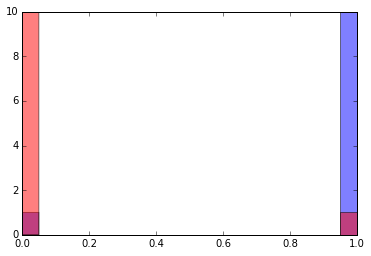

In [55]:
y_proba = folding.predict_proba(X_data)[:, 1]
y_predict = folding.predict(X_data)

y_proba = y_predict

from sklearn.metrics import roc_auc_score
print roc_auc_score(y_data, y_proba)

plt.hist(y_proba[y_data==1], label='1', color='b', bins=20, alpha=0.5)
plt.hist(y_proba[y_data==0], label='0', color='r', bins=20, alpha=0.5)
plt.ylim(0,10)
plt.show()

In [56]:
N = ((y_predict == y_data)*1).sum()
N_mis = ((y_predict != y_data)*1).sum()

print N, N_mis

394 2


# Tracks Reconstruction

In [57]:
from baseline import SimpleTemplateMatching
from reconstruction import TracksReconstruction2D
from combination import Combinator, SuperCombinator

from metrics import TracksReconstractionMetrics, CombinatorQuality

In [58]:
%%time
event_ids = event_ids_test

tracks = {}
tracks_comb = {}

tracks_metrics_before_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_y = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_stereo = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])
tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Stereo12', 'Stations12', 
                                        'Y34', 'Stereo34', 'Stations34', 'Combination', 'Matching'])

for event_id in event_ids:
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    weights12 = 1. / numpy.sqrt(event12.dist2Wire.values**2 + 0.01**2)
    weights34 = 1. / numpy.sqrt(event34.dist2Wire.values**2 + 0.01**2)
    
    # Select model for the tracks reconstruction
    stm_y = SimpleTemplateMatching(n_max_hits=16, n_min_hits=7, window_width=0.7)
    stm_stereo = SimpleTemplateMatching(n_max_hits=16, n_min_hits=6, window_width=15)
    
    
    # Tracks reconstruction before the magnet
    tr2d12 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d12.fit(event12, weights12)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)

    tracks_metrics_before_y.loc[len(tracks_metrics_before_y)] = [event_id, 
                                                                 trm12.avg_efficiency_y_, 
                                                                 trm12.recognition_efficiency_y_, 
                                                                 trm12.ghost_rate_y_, 
                                                                 trm12.clone_rate_y_]

    tracks_metrics_before_stereo.loc[len(tracks_metrics_before_stereo)] = [event_id, 
                                                                 trm12.avg_efficiency_stereo_, 
                                                                 trm12.recognition_efficiency_stereo_, 
                                                                 trm12.ghost_rate_stereo_, 
                                                                 trm12.clone_rate_stereo_]
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    tr2d34 = TracksReconstruction2D(model_y=stm_y, model_stereo=stm_stereo)
    tr2d34.fit(event34, weights34)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_y.loc[len(tracks_metrics_after_y)] = [event_id, 
                                                                 trm34.avg_efficiency_y_, 
                                                                 trm34.recognition_efficiency_y_, 
                                                                 trm34.ghost_rate_y_, 
                                                                 trm34.clone_rate_y_]

    tracks_metrics_after_stereo.loc[len(tracks_metrics_after_stereo)] = [event_id, 
                                                                 trm34.avg_efficiency_stereo_, 
                                                                 trm34.recognition_efficiency_stereo_, 
                                                                 trm34.ghost_rate_stereo_, 
                                                                 trm34.clone_rate_stereo_]
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
    
    # Save the reconstructed tracks
    tracks[event_id] = {'labels12':labels12, 'params12':tracks_params12, 
                        'labels34':labels34, 'params34':tracks_params34}
    
    
    
    # Combination of the tracks before and after the magnet
    comb = SuperCombinator(classifier=folding.estimators[0]) #
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_quality)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    pass_stages.loc[len(pass_stages)] = numpy.array([1, 
                                                     (trm12.recognition_efficiency_y_ == 1)*1, 
                                                     (trm12.recognition_efficiency_stereo_ >= 0.5)*1, 
                                                     (trm12.recognition_efficiency_ == 1)*1,
                                                     (trm34.recognition_efficiency_y_ == 1)*1, 
                                                     (trm34.recognition_efficiency_stereo_ >= 0.5)*1, 
                                                     (trm34.recognition_efficiency_ == 1)*1, 
                                                     (cq.n_combined_ >= 2)*1,
                                                     (cq.reco_eff_ == 1)*1]).cumprod()
    
    # Save the tracks combination
    tracks_comb[event_id] = {'tracks_combinations':comb.tracks_combinations_, 
                             'charges':comb.charges_, 
                             'inv_momentums':comb.inv_momentums_}

CPU times: user 1min 57s, sys: 4.01 s, total: 2min 1s
Wall time: 2min 6s


# Quality

# Stations 1&2

### Y-views

In [59]:
tracks_metrics_before_y.mean(axis=0)

EventID      2567.573684
AvgEff          0.989085
RecoEff         0.989474
GhostRate       0.009649
CloneRate       0.000877
dtype: float64

### Stereo-views

In [60]:
tracks_metrics_before_stereo.mean(axis=0)

EventID      2567.573684
AvgEff          0.975111
RecoEff         0.967544
GhostRate       0.010526
CloneRate       0.000877
dtype: float64

### Stations 1&2

In [61]:
tracks_metrics_before_all.mean(axis=0)

EventID      2567.573684
AvgEff          0.982108
RecoEff         0.987719
GhostRate       0.010526
CloneRate       0.000877
dtype: float64

### Track efficiency

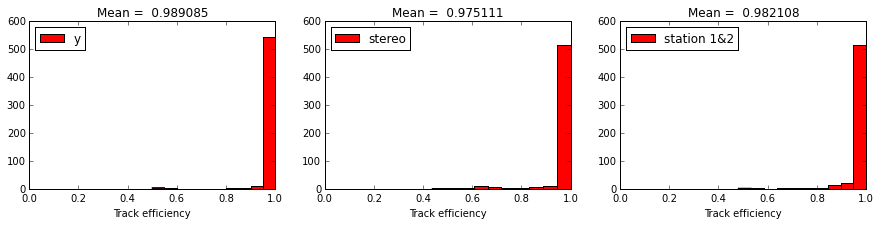

In [62]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

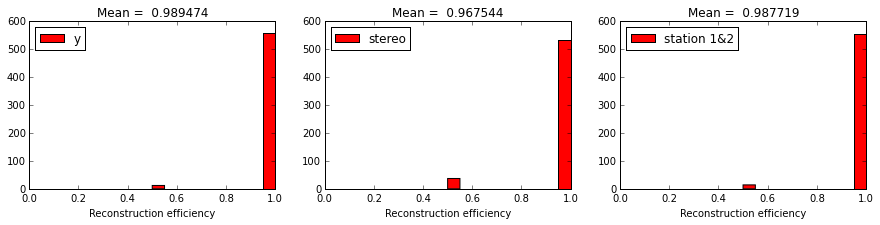

In [63]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_before_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_before_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

### Y-views

In [64]:
tracks_metrics_after_y.mean(axis=0)

EventID      2567.573684
AvgEff          0.991272
RecoEff         0.989474
GhostRate       0.014912
CloneRate       0.001754
dtype: float64

### Stereo-views

In [65]:
tracks_metrics_after_stereo.mean(axis=0)

EventID      2567.573684
AvgEff          0.982566
RecoEff         0.972807
GhostRate       0.018421
CloneRate       0.000877
dtype: float64

### Station 3&4

In [66]:
tracks_metrics_after_all.mean(axis=0)

EventID      2567.573684
AvgEff          0.985973
RecoEff         0.985088
GhostRate       0.014912
CloneRate       0.000877
dtype: float64

### Tracks efficiency

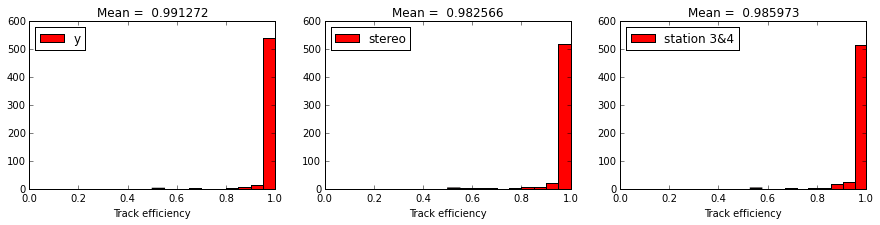

In [67]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

### Reconstruction efficiency

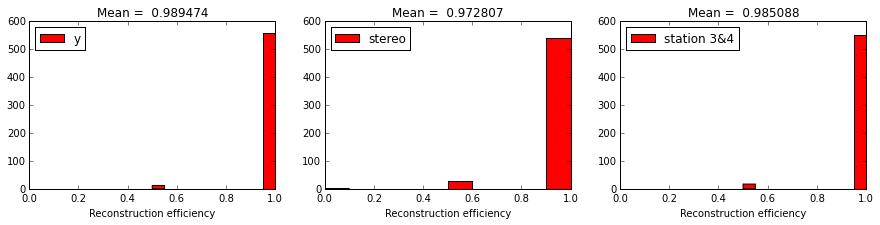

In [68]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff_y = tracks_metrics_after_y.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_y).mean())
plt.hist(eff_y, label='y')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
eff_stereo = tracks_metrics_after_stereo.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_stereo).mean())
plt.hist(eff_stereo, label='stereo')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

In [69]:
combinations_quality.mean(axis=0)

EventID      2567.573684
RecoEff         0.952632
GhostRate       0.009649
CloneRate       0.000000
NCombined       1.905263
dtype: float64

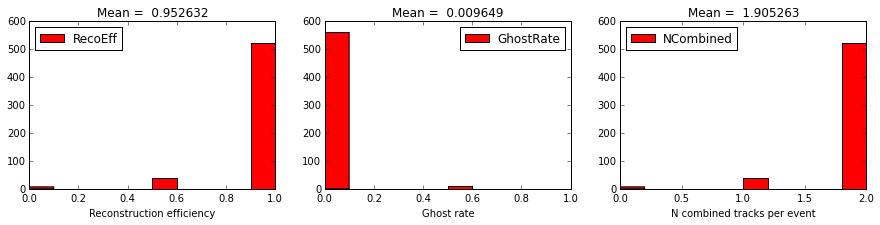

In [70]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

91.7543859649


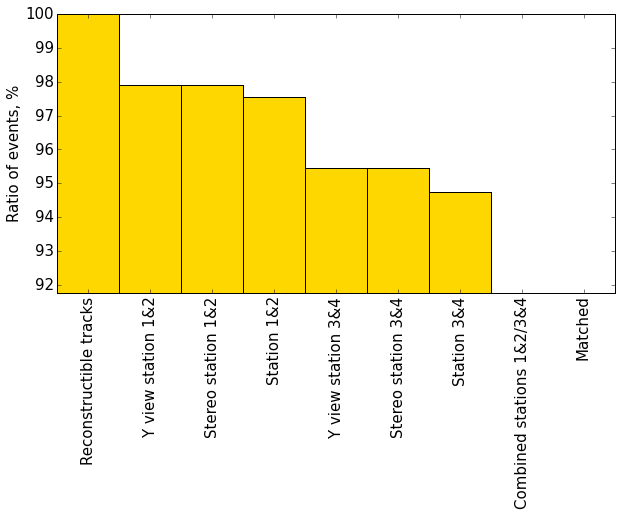

In [71]:
bar_labels = ['Reconstructible tracks', 
              'Y view station 1&2', 
              'Stereo station 1&2', 
              'Station 1&2',
              'Y view station 3&4', 
              'Stereo station 3&4',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages.sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

In [72]:
bar_values

array([ 100.        ,   97.89473684,   97.89473684,   97.54385965,
         95.43859649,   95.43859649,   94.73684211,   91.75438596,
         91.75438596])

# Momentum

In [73]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

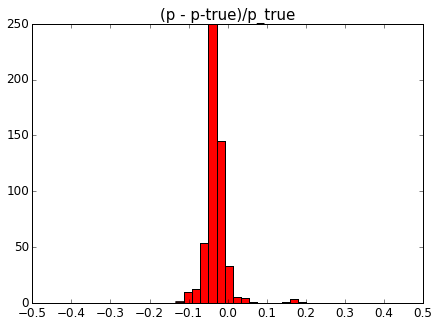

In [74]:
plt.figure(figsize=(7, 5))
plt.hist(p_err, bins=50)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()